In [1]:
# importing dependencies here
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# scikit Learn
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

In [2]:
# reading the input file
fish_data = pd.read_csv("fish_participant.csv")

In [3]:
# checking first 5 records
fish_data.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
1,Perch,110.0,20.0,22.0,23.5,5.5225,3.9950
2,Roach,160.0,20.5,22.5,25.3,7.0334,3.8203
3,Parkki,60.0,14.3,15.5,17.4,6.5772,2.3142
4,Bream,700.0,30.4,33.0,38.3,14.8604,5.2854


### Exploratory Data Analysis

In [4]:
# checking the data types
fish_data.dtypes

Species     object
Weight     float64
Length1    float64
Length2    float64
Length3    float64
Height     float64
Width      float64
dtype: object

The data types look okay.

In [5]:
# checking for missing values
fish_data.isnull().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

There is no missing data present.

In [6]:
fish_data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000
mean,401.676577,26.447748,28.615315,31.422523,9.015701,4.480407
std,338.510755,9.795155,10.498781,11.306311,4.225369,1.696240
min,5.900000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,142.500000,20.000000,22.000000,23.500000,6.138850,3.551400
50%,300.000000,25.400000,27.500000,30.100000,8.145400,4.335000
75%,682.500000,33.750000,36.250000,40.150000,12.143400,5.658300
max,1550.000000,56.000000,60.000000,64.000000,18.957000,8.142000


For the target variable "Weight", the difference between the min and max value semms to be significantly large. <br>
There could be some outliers present possibly that I will handle later in this code.

In [7]:
# checking for correlations
corr = fish_data.corr()
corr.style.background_gradient(cmap="ocean")

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.900963,0.904090,0.909553,0.738316,0.893379
Length1,0.900963,1.000000,0.999468,0.991363,0.621648,0.862612
Length2,0.904090,0.999468,1.000000,0.993695,0.637353,0.869217
Length3,0.909553,0.991363,0.993695,1.000000,0.702567,0.872672
Height,0.738316,0.621648,0.637353,0.702567,1.000000,0.782936
Width,0.893379,0.862612,0.869217,0.872672,0.782936,1.000000


All the features are showing strong correlation with the target vaibale weight.<br>
The 3 Length variables are showing collinearity. I will handle this later in this code.

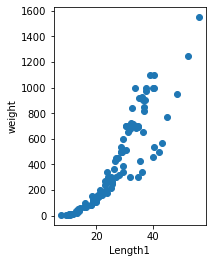

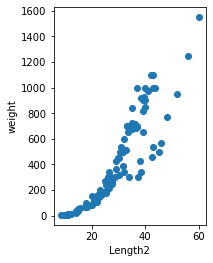

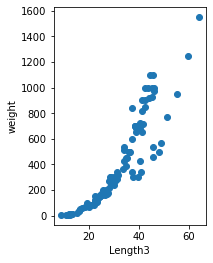

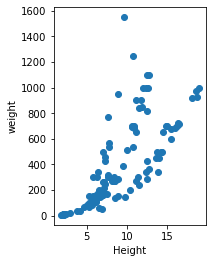

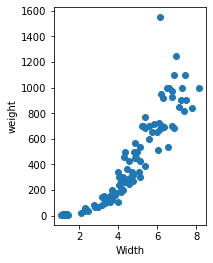

In [8]:
# checking for linear relationship between features and the target variable

numerical = ["Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:
    plt.subplot(1, 2, 1)
    plt.scatter(x=fish_data[feature], y=fish_data["Weight"])
    plt.xlabel(feature)
    plt.ylabel("weight")
    plt.show()
   

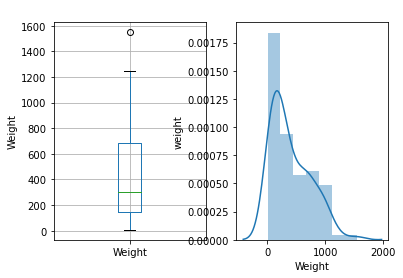

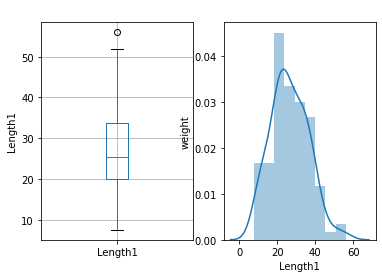

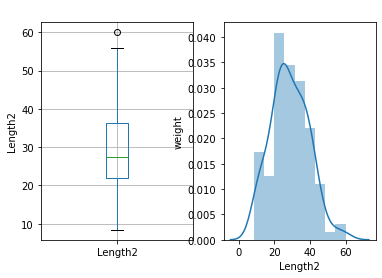

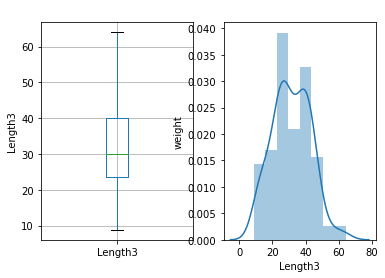

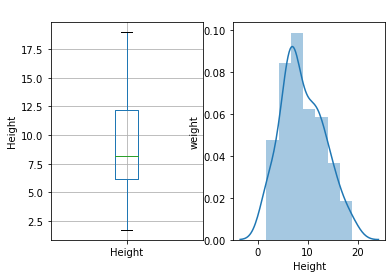

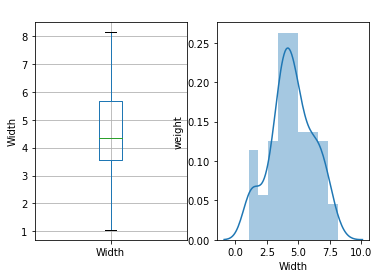

In [9]:
# checking for outliers and distribution

numerical = ["Weight", "Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:
   
    plt.subplot(1, 2, 1)
    fig = fish_data.boxplot(column=feature)
    fig.set_title(" ")
    fig.set_ylabel(feature)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(fish_data[feature])
    fig.set_ylabel("weight")
    fig.set_xlabel(feature)

    plt.show()

There outliers present in target variable "Weight" and features "Lenght1", "Length2". Rest of the data looks good.<br>
The distributions look skewed. 

In [10]:
# finding the outliers
cols_with_ouliers = ["Weight", "Length1", "Length2"]

for col in numerical:
    df = fish_data[col]
    df_Q1 = df.quantile(0.25)
    df_Q3 = df.quantile(0.75)
    df_IQR = df_Q3 - df_Q1
    df_lowerend = df_Q1 - (1.5 * df_IQR)
    df_upperend = df_Q3 + (1.5 * df_IQR)

    df_outliers = df[(df < df_lowerend) | (df > df_upperend)]
    print(df_outliers)

13    1550.0
Name: Weight, dtype: float64
13    56.0
Name: Length1, dtype: float64
13    60.0
Name: Length2, dtype: float64
Series([], Name: Length3, dtype: float64)
Series([], Name: Height, dtype: float64)
Series([], Name: Width, dtype: float64)


Record at row # 13 seems to be the outlier for weight, lenght1 and length2. <br>
Dropping this record from the dataset.

In [11]:
# dropping the outlier row # 13
fish_data = fish_data.drop([13])

In [12]:
# trying to see if log conversion normalizes the distribution of features and the target variable to some extent
fish_data["Weight"] = np.log(fish_data["Weight"])
fish_data["Length1"] = np.log(fish_data["Length1"])
fish_data["Length2"] = np.log(fish_data["Length2"])
fish_data["Length3"] = np.log(fish_data["Length3"])
fish_data["Height"] = np.log(fish_data["Height"])
fish_data["Width"] = np.log(fish_data["Width"])

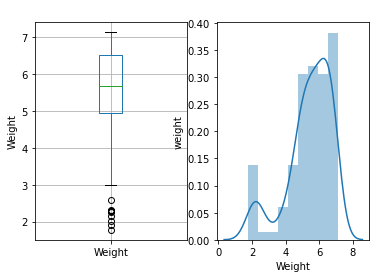

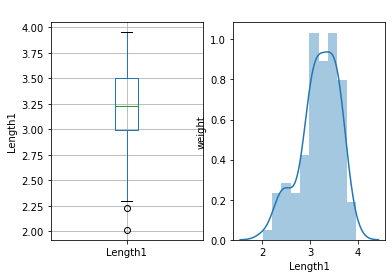

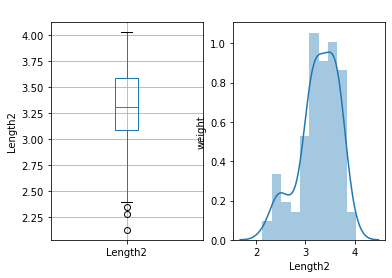

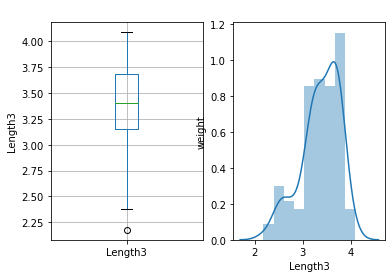

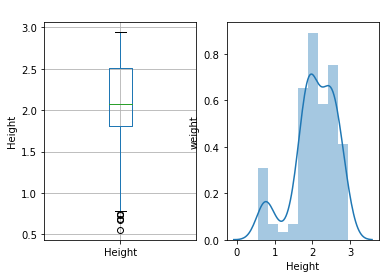

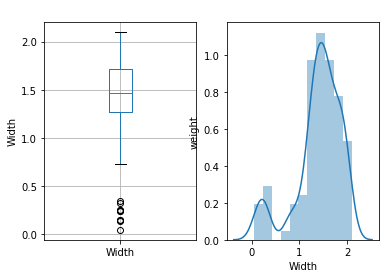

In [13]:
# checking for outliers and distribution

numerical = ["Weight", "Length1", "Length2", "Length3", "Height", "Width"]

for feature in numerical:
    plt.subplot(1, 2, 1)
    fig = fish_data.boxplot(column=feature)
    fig.set_title(" ")
    fig.set_ylabel(feature)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(fish_data[feature])
    fig.set_ylabel("weight")
    fig.set_xlabel(feature)

    plt.show()

Perch        39
Bream        24
Roach        14
Pike         11
Smelt        10
Parkki        8
Whitefish     4
Name: Species, dtype: int64


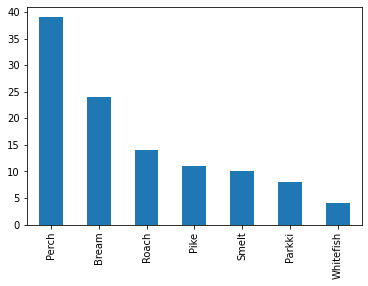

In [14]:
# checking the categorical feature - Species
print(fish_data["Species"].value_counts())
fish_data["Species"].value_counts().plot(kind="bar")
plt.show()

This catgorical feature will need encoding. I will handle this using OneHotEncoder later in this code. 

In [15]:
# checking for collinerity between the 3 length variables
fish_data[["Length1", "Length2", "Length3"]].corr()

,Length1,Length2,Length3
Length1,1.000000,0.999338,0.994402
Length2,0.999338,1.000000,0.995762
Length3,0.994402,0.995762,1.000000


The 3 lenght variables are highly correlated. Let's check their values.

In [16]:
fish_data[["Length1", "Length2", "Length3"]].head(10)

,Length1,Length2,Length3
0,3.277145,3.367296,3.526361
1,2.995732,3.091042,3.157000
2,3.020425,3.113515,3.230804
3,2.660260,2.740840,2.856470
4,3.414443,3.496508,3.645450
5,2.624669,2.708050,2.772589
6,3.414443,3.496508,3.650658
7,3.234749,3.314186,3.363842
8,2.230014,2.282382,2.379546
9,3.144152,3.234749,3.401197


Since Length3 values are the highest for each row, it is probably the Total Length of the fish. <br>
So keeping Length3 and dropping the other two length variables from the dataset. 

In [17]:
fish_data.drop(["Length1", "Length2"], axis=1)

,Species,Weight,Length3,Height,Width
0,Bream,6.063785,3.526361,2.521239,1.635885
1,Perch,4.700480,3.157000,1.708831,1.385044
2,Roach,5.075174,3.230804,1.950670,1.340329
3,Parkki,4.094345,2.856470,1.883609,0.839064
4,Bream,6.551080,3.645450,2.698700,1.664948
...,...,...,...,...,...
106,Perch,5.283204,3.295837,1.881143,1.444327
107,Parkki,4.941642,3.144152,2.144480,1.192224
108,Roach,4.700480,3.139833,1.819326,1.222510
109,Perch,6.529419,3.663562,2.387018,1.926290


### Model Creation

In [18]:
# dividing the data into features and target variable
X = fish_data.drop("Weight", axis=1)
y = fish_data["Weight"]

In [19]:
fish_data.columns

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height',
       'Width'],
      dtype='object')

### Linear Regression

In [20]:
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)

X = ct.fit_transform(X)

# # splitting the data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

pipe = make_pipeline(StandardScaler(),
                     LinearRegression())

# fitting the data
pipe.fit(X_train, y_train)

# X_test = ct.transform(X_test)

# predicting
y_predict = pipe.predict(X_test)


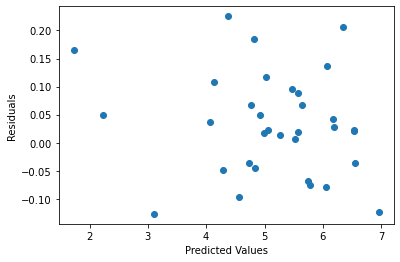

In [21]:
plt.scatter(y_predict, y_test - y_predict)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Text(0.5, 1.0, 'Normal Q-Q plot')

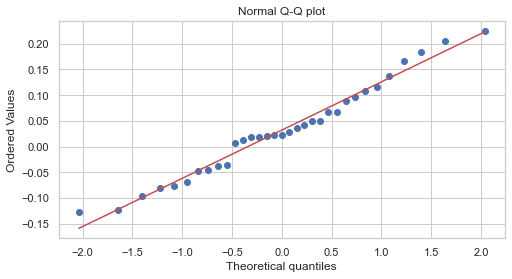

In [22]:
#Normal Q-Q plot
from scipy import stats
sns.set(style="whitegrid")

plt.figure(figsize=(8,4))
stats.probplot(y_test - y_predict, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

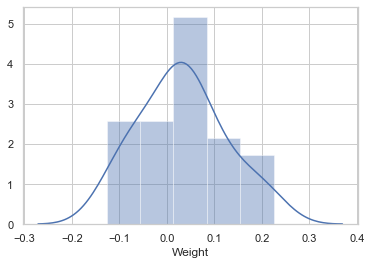

In [23]:
sns.distplot(y_test - y_predict)

In [24]:
# Test MSE and R2
print(f"\nLinear Regression Test MSE: {mean_squared_error(y_test, y_predict)}")
print(f"Linear Regression Test R2: {r2_score(y_test, y_predict)}")


Linear Regression Test MSE: 0.009112059403102547
Linear Regression Test R2: 0.9931416816053668


In [25]:
# cross validation score
cv_score = np.mean((cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error'))*-1)
print("\nCross Validation Score", cv_score)


Cross Validation Score 0.009597643284183915


### Lasso

In [26]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)

X = ct.fit_transform(X)

# # splitting the data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

lasso_pipe = make_pipeline(StandardScaler(),
                     Lasso())

parameters = {'lasso__alpha':[1e-15,1e-10,1e-8,1e-3,1e-2,1,5,10,20,30,35,40]}

lasso_regressor = GridSearchCV(lasso_pipe, parameters, scoring = 'neg_mean_squared_error', cv = 5)

lasso_regressor.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('lasso',
                                        Lasso(alpha=1.0, copy_X=True,
                                              fit_intercept=True, max_iter=1000,
                                              normalize=False, positive=False,
                                              precompute=False,
                                              random_state=None,
                                              selection='cyclic', tol=0.0001,
                                              warm_start=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
       

In [27]:
print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)
prediction_lasso = lasso_regressor.predict(X_test)

{'lasso__alpha': 0.01}
-0.009222011982682172


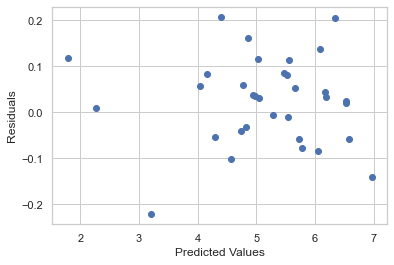

In [28]:

plt.scatter(prediction_lasso, y_test - prediction_lasso)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Text(0.5, 1.0, 'Normal Q-Q plot')

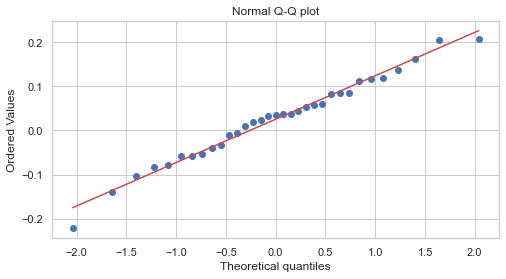

In [29]:

#Normal Q-Q plot
sns.set(style="whitegrid")

plt.figure(figsize=(8,4))
stats.probplot(y_test - prediction_lasso, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

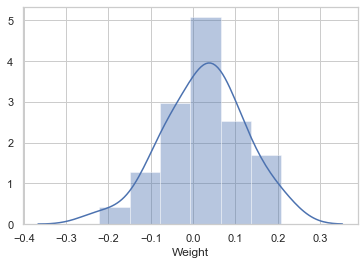

In [30]:
sns.distplot(y_test - prediction_lasso)

In [31]:
# MSE for test data
print('Test MSE:', mean_squared_error(y_test, prediction_lasso))

# R2 for test data
print("\nCoefficient of determination R^2 <-- on test set:", r2_score(y_test, prediction_lasso))

# cross validation score
cv_score = np.mean((cross_val_score(lasso_regressor, X, y, cv=5, scoring='neg_mean_squared_error'))*-1)
print("\nCross Validation Score", cv_score)

Test MSE: 0.009521274725205937

Coefficient of determination R^2 <-- on test set: 0.9928336799948866

Cross Validation Score 0.010131132808994974


### Random Forest

In [32]:
ct = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0])],   # The column numbers to be transformed (here is [0] but can be [0, 1, 3])
    remainder='passthrough'                                         # Leave the rest of the columns untouched
)

X = ct.fit_transform(X)

# # splitting the data into train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

pipe = make_pipeline(RandomForestRegressor(n_estimators = 100))

# fitting the data
pipe.fit(X_train, y_train)

# X_test = ct.transform(X_test)

# predicting
rf_predictions = pipe.predict(X_test)

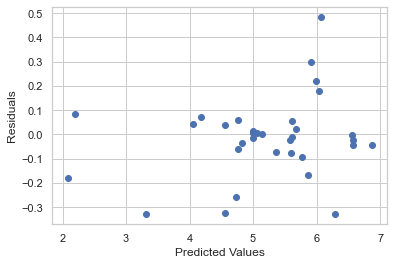

In [33]:

plt.scatter(rf_predictions, y_test - rf_predictions)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Text(0.5, 1.0, 'Normal Q-Q plot')

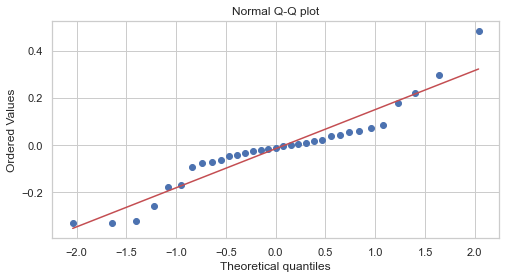

In [34]:
#Normal Q-Q plot
sns.set(style="whitegrid")

plt.figure(figsize=(8,4))
stats.probplot(y_test - rf_predictions, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [35]:
# test MSE
print(f"Test MSE: {mean_squared_error(y_test, rf_predictions)}")

# test R2
print(f"\nCoefficient of determination R^2 <-- on test set: {pipe.score(X_test, y_test)}")

# cross validation score
cv_score = np.mean((cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error'))*-1)
print("\nCross Validation Score", cv_score)

Test MSE: 0.027457274105439355

Coefficient of determination R^2 <-- on test set: 0.9793339003036237

Cross Validation Score 0.028183269839550957
